Import price data to train and test on

In [184]:
import pandas as pd

prices = pd.read_excel('Price.xlsx')
prices = prices.loc[prices['PriceArea'] == 'DK1']
prices = prices['PriceDKK'].values
print(len(prices))
# Temporarily limit the number of prices to 100
prices = prices[:10000]

23783


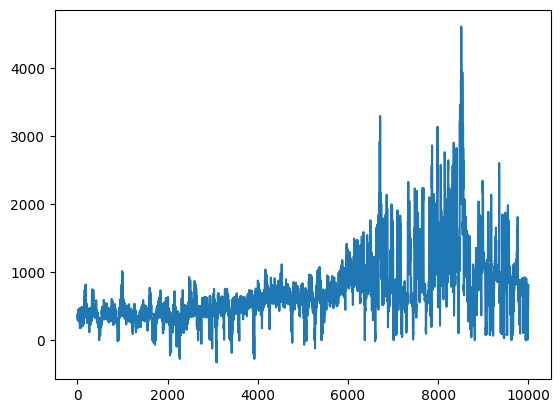

In [185]:
import matplotlib.pyplot as plt
plt.plot(prices)

Define actions and states, and allowed actions in different states. Only depends on SOC

In [186]:
import numpy as np

ACTIONS = ["Charge", "Discharge", "Do nothing"]
PRICE_STATE = ["Lowest", "Lower", "Medium", "Higher", "Highest"]
SOC_STATE = ["20%", "40%", "60%", "80%", "100%"]
ALLOWED_ACTIONS = {"20%":  ["Charge",              "Do nothing"], 
                   "40%":  ["Charge", "Discharge", "Do nothing"],
                   "60%":  ["Charge", "Discharge", "Do nothing"],
                   "80%":  ["Charge", "Discharge", "Do nothing"],
                   "100%": [          "Discharge", "Do nothing"],}

# Initialize the lookup-table
P_ssa_array = np.empty((len(PRICE_STATE), len(SOC_STATE), len(ACTIONS)), dtype=object)

Prepare and estimate probability of transitioning from one price state to another

In [187]:
# Split prices into 5 states
#percentiles = np.percentile(prices, np.linspace(0, 100, len(PRICE_STATE) + 1))
#price_states = np.array([(percentiles[i] <= prices) & (prices < percentiles[i+1]) for i in range(len(PRICE_STATE))], dtype=int)


# Compute probability of being in a price state given the current price state.
# Assumed independent of SOC state and action
# price_prop = P(s'|s) -> price_prop[i,j] = P(s'=j|s=i)
#price_prop = (price_states @ np.roll(price_states,-1).T) / (price_states).sum(axis=1)


# Generate representative prices
#price_representative = np.array([prices[price_states[i] == 1].mean() for i in range(len(PRICE_STATE))])

In [188]:
#make the above cell into a function that takes in the prices and returns the price_prop and price_representative?
def price_state(prices):
    percentiles = np.percentile(prices, np.linspace(0, 100, len(PRICE_STATE) + 1))
    price_states = np.array([(percentiles[i] <= prices) & (prices < percentiles[i+1]) for i in range(len(PRICE_STATE))], dtype=int)
    price_prop = (price_states @ np.roll(price_states,-1).T) / (price_states).sum(axis=1)
    price_representative = np.array([prices[price_states[i] == 1].mean() for i in range(len(PRICE_STATE))])
    return price_prop, price_representative, percentiles




Compute the transitioning matrix for each given state (price and SOC) and action. Limit allowed actions

In [189]:
"""
for i, ps in enumerate(PRICE_STATE):
    for j, ss in enumerate(SOC_STATE):
        for k, ac in enumerate(ACTIONS):
            # Given that we are in state ps, ss and take action ac
            # what is the probability of transitioning to each state (ps', ss')
            # i.e. P(s'=(ps', ss')| s=(ps, ss), ac)
            if ac in ALLOWED_ACTIONS[ss]:
                if ac == "Charge":
                    c = 1
                elif ac == "Discharge":
                    c = -1
                else:
                    c = 0
                SOC_prop = np.zeros((len(SOC_STATE)))
                SOC_prop[j+c] = 1
                # state_trans = P(price'|price) * P(soc'|soc, action)
                state_trans = price_prop[i,:].reshape(-1,1) @ SOC_prop.reshape(1,-1)
                P_ssa[i,j,k] = state_trans
            else:
                P_ssa[i,j,k] = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
"""                

'\nfor i, ps in enumerate(PRICE_STATE):\n    for j, ss in enumerate(SOC_STATE):\n        for k, ac in enumerate(ACTIONS):\n            # Given that we are in state ps, ss and take action ac\n            # what is the probability of transitioning to each state (ps\', ss\')\n            # i.e. P(s\'=(ps\', ss\')| s=(ps, ss), ac)\n            if ac in ALLOWED_ACTIONS[ss]:\n                if ac == "Charge":\n                    c = 1\n                elif ac == "Discharge":\n                    c = -1\n                else:\n                    c = 0\n                SOC_prop = np.zeros((len(SOC_STATE)))\n                SOC_prop[j+c] = 1\n                # state_trans = P(price\'|price) * P(soc\'|soc, action)\n                state_trans = price_prop[i,:].reshape(-1,1) @ SOC_prop.reshape(1,-1)\n                P_ssa[i,j,k] = state_trans\n            else:\n                P_ssa[i,j,k] = np.zeros((len(PRICE_STATE), len(SOC_STATE)))\n'

In [190]:
"""

#make the above cell into a function that takes in the price_prop and returns the P_ssa?
def P_ssa(price_prop, P_ssa_array):
    for i, ps in enumerate(PRICE_STATE):
        for j, ss in enumerate(SOC_STATE):
            for k, ac in enumerate(ACTIONS):
                # Given that we are in state ps, ss and take action ac
                # what is the probability of transitioning to each state (ps', ss')
                # i.e. P(s'=(ps', ss')| s=(ps, ss), ac)
                if ac in ALLOWED_ACTIONS[ss]:
                    if ac == "Charge":
                        c = 1
                    elif ac == "Discharge":
                        c = -1
                    else:
                        c = 0
                    SOC_prop = np.zeros((len(SOC_STATE)))
                    SOC_prop[j+c] = 1
                    # state_trans = P(price'|price) * P(soc'|soc, action)
                    state_trans = price_prop[i,:].reshape(-1,1) @ SOC_prop.reshape(1,-1)
                    P_ssa[i,j,k] = state_trans
                else:
                    P_ssa[i,j,k] = np.zeros((len(PRICE_STATE), len(SOC_STATE)))

    return P_ssa

"""    

'\n\n#make the above cell into a function that takes in the price_prop and returns the P_ssa?\ndef P_ssa(price_prop, P_ssa_array):\n    for i, ps in enumerate(PRICE_STATE):\n        for j, ss in enumerate(SOC_STATE):\n            for k, ac in enumerate(ACTIONS):\n                # Given that we are in state ps, ss and take action ac\n                # what is the probability of transitioning to each state (ps\', ss\')\n                # i.e. P(s\'=(ps\', ss\')| s=(ps, ss), ac)\n                if ac in ALLOWED_ACTIONS[ss]:\n                    if ac == "Charge":\n                        c = 1\n                    elif ac == "Discharge":\n                        c = -1\n                    else:\n                        c = 0\n                    SOC_prop = np.zeros((len(SOC_STATE)))\n                    SOC_prop[j+c] = 1\n                    # state_trans = P(price\'|price) * P(soc\'|soc, action)\n                    state_trans = price_prop[i,:].reshape(-1,1) @ SOC_prop.reshape(1,-1)\

In [191]:
# Define the function with the correct array variable
def P_ssa(price_prop, P_ssa_array):
    for i, ps in enumerate(PRICE_STATE):
        for j, ss in enumerate(SOC_STATE):
            for k, ac in enumerate(ACTIONS):
                # Given that we are in state ps, ss and take action ac
                # what is the probability of transitioning to each state (ps', ss')
                # i.e. P(s'=(ps', ss')| s=(ps, ss), ac)
                if ac in ALLOWED_ACTIONS[ss]:
                    if ac == "Charge":
                        c = 1
                    elif ac == "Discharge":
                        c = -1
                    else:
                        c = 0
                    SOC_prop = np.zeros((len(SOC_STATE)))
                    if 0 <= j + c < len(SOC_STATE):  # Boundary check
                        SOC_prop[j + c] = 1
                    # state_trans = P(price'|price) * P(soc'|soc, action)
                    state_trans = price_prop[i, :].reshape(-1, 1) @ SOC_prop.reshape(1, -1)
                    P_ssa_array[i, j, k] = state_trans  # Assign to the correct variable
                else:
                    P_ssa_array[i, j, k] = np.zeros((len(PRICE_STATE), len(SOC_STATE)))

    return P_ssa_array


In [192]:
#price_propp, price_representative = price_state(prices)
#P_ssa = P_ssa(price_propp, P_ssa_array)

#print(P_ssa)

Generate reward function

In [193]:
def rewards(price_state, action, price_representative):
    if action == "Charge":
        reward = - 100 * price_representative[PRICE_STATE.index(price_state)]
    elif action == "Discharge":
        reward = 100 * price_representative[PRICE_STATE.index(price_state)]
    else:
        reward = 0
    return reward

In [194]:
"""

def value_iteration(price_representatives,P_ssa,gamma = 0.9, epsilon=1e-6):
    # Initialize the value function with V(s) = 0
    V = np.ones((len(PRICE_STATE), len(SOC_STATE)))*0
    V_list = []
    V_list.append(V)
    V_new_list = []
    count = 0
    while True:
        # Initialize the new value function
        V_new = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
        V_new_list.append(V_new)
        for i, ps in enumerate(PRICE_STATE):
            for j, ss in enumerate(SOC_STATE):
                # print(f"Allowed actions for SOC_STATE {ss}: {ALLOWED_ACTIONS[ss]}")
                # Update the value function
                V_new[i,j] = np.max([rewards(ps, ac, price_representatives) + gamma * np.sum(P_ssa[i,j,k] * V) for k, ac in enumerate(ACTIONS) if ac in ALLOWED_ACTIONS[ss]])
            # Check for convergence
        if np.max(np.abs(V - V_new)) < epsilon:
            print(f"Converged after {count} iterations")
            break
        # print(f"Iteration {count}: max change = {np.max(np.abs(V - V_new))}")
        V = V_new
        V_list.append(V)
        count += 1
        
        

    return V, count, V_list, V_new_list

"""    

'\n\ndef value_iteration(price_representatives,P_ssa,gamma = 0.9, epsilon=1e-6):\n    # Initialize the value function with V(s) = 0\n    V = np.ones((len(PRICE_STATE), len(SOC_STATE)))*0\n    V_list = []\n    V_list.append(V)\n    V_new_list = []\n    count = 0\n    while True:\n        # Initialize the new value function\n        V_new = np.zeros((len(PRICE_STATE), len(SOC_STATE)))\n        V_new_list.append(V_new)\n        for i, ps in enumerate(PRICE_STATE):\n            for j, ss in enumerate(SOC_STATE):\n                # print(f"Allowed actions for SOC_STATE {ss}: {ALLOWED_ACTIONS[ss]}")\n                # Update the value function\n                V_new[i,j] = np.max([rewards(ps, ac, price_representatives) + gamma * np.sum(P_ssa[i,j,k] * V) for k, ac in enumerate(ACTIONS) if ac in ALLOWED_ACTIONS[ss]])\n            # Check for convergence\n        if np.max(np.abs(V - V_new)) < epsilon:\n            print(f"Converged after {count} iterations")\n            break\n        # print

In [195]:
import numpy as np

def value_policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representatives, P_ssa, gamma=0.9, epsilon=1e-6):
    """
    Perform value iteration for a 2D state space with given parameters.

    Parameters:
    - PRICE_STATE: List of discrete price states
    - SOC_STATE: List of discrete state of charge (SOC) states
    - ALLOWED_ACTIONS: A dictionary mapping each SOC state to a list of valid actions
    - rewards: A function `rewards(price_state, action)` that returns the immediate reward
    - P_ssa: Transition probability matrix of shape (len(PRICE_STATE), len(SOC_STATE), len(actions), len(PRICE_STATE), len(SOC_STATE))
    - gamma: Discount factor (default 0.9)
    - epsilon: Convergence threshold (default 1e-6)

    Returns:
    - V: Optimal value function of shape (len(PRICE_STATE), len(SOC_STATE))
    - policy: Optimal policy for each state, of shape (len(PRICE_STATE), len(SOC_STATE))
    """
    # Initialize the value function to 0 for all states
    V = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
    policy = np.zeros((len(PRICE_STATE), len(SOC_STATE)), dtype=object)
    V_list = []
    V_list.append(V)
    V_new_list = []
    count = 0
    while True:
        # Initialize the new value function
        V_new = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
        V_new_list.append(V_new)
        
        for i, ps in enumerate(PRICE_STATE):  # Iterate over price states
            for j, ss in enumerate(SOC_STATE):  # Iterate over SOC states
                # Get the valid actions for the current SOC state
                valid_actions = ALLOWED_ACTIONS[ss]

                # Compute the expected value for each valid action
                action_values = []
                for k, action in enumerate(ACTIONS):
                    if action in ALLOWED_ACTIONS[ss]:
               
                        immediate_reward = rewards(ps, action, price_representatives)

                        # Compute the expected future value
                        expected_future_value = 0
                        for i_next, ps_next in enumerate(PRICE_STATE):
                            for j_next, ss_next in enumerate(SOC_STATE):
                                expected_future_value += P_ssa[i, j, k][i_next, j_next] * V[i_next, j_next]

                        # Combine immediate reward and discounted future value
                        action_value = immediate_reward + gamma * expected_future_value
                        action_values.append(action_value)

                # Update the value function with the max action value
                V_new[i, j] = max(action_values)

                # Store the optimal action index
                policy[i, j] = valid_actions[np.argmax(action_values)]

        # Check for convergence
        count += 1
        if np.max(np.abs(V - V_new)) < epsilon:
            print(f"Converged after {count} iterations")
            break

        # Update the value function
        V = V_new

    return V, policy, count, V_list, V_new_list

Split into training and testing

In [196]:
#can you split my dataset into a trining and test set with a split at 80% and 20% respectively withot dividing x and y values   

from sklearn.model_selection import train_test_split

train, test = train_test_split(prices, test_size=0.2, random_state=42)


In [197]:
len(train), len(test)

(8000, 2000)

Running training data  

In [198]:
price_prop_train, price_representative_train, percentiles_train = price_state(train)
P_ssa_train = P_ssa(price_prop_train, P_ssa_array)
V_train_p, policy_train_p, count_train_p, V_list_train_p, V_new_list_train_p = value_policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative_train, P_ssa_train, gamma=0.9, epsilon=1e-6)




Converged after 226 iterations


In [199]:
policy_train_p


array([['Charge', 'Charge', 'Charge', 'Charge', 'Do nothing'],
       ['Charge', 'Charge', 'Do nothing', 'Discharge', 'Discharge'],
       ['Charge', 'Do nothing', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge']],
      dtype=object)

Applying policy from MDP of training data to test data 

In [200]:
import numpy as np

def simulate_policy_with_boundaries(real_prices, policy, percentiles_train, PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20):
    """
    Simulate hourly operation of a battery using a policy matrix and price state boundaries.

    Parameters:
    - real_prices: List of hourly price data.
    - policy: Policy matrix of shape (len(PRICE_STATE), len(SOC_STATE)).
    - percentiles_train: The percentiles defining the price states (for digitizing the real prices).
    - PRICE_STATE: List of price state labels.
    - SOC_STATE: List of discrete SOC levels (percentage).
    - max_soc_percent: Maximum state of charge (percentage).
    - soc_step_percent: SOC increment in percentage (20% = 100 MW).

    Returns:
    - total_cost: Total cumulative cost/revenue from simulation.
    - hourly_profits: A list of profits/revenues for each hour.
    """
    # Initialize variables
    soc_percentage = 0  # Starting state of charge in percentage (0% means 0 MWh capacity)
    total_cost = 0
    hourly_profits = []  # List to store the profit for each hour

    # Map SOC_STATE to percentage levels (["20%", "40%", "60%", "80%", "100%"])
    soc_levels_percentage = [int(s.strip('%')) for s in SOC_STATE]  # Convert SOC to percentage

    # Simulate hourly operation
    for hour, price in enumerate(real_prices):
        # Determine price state (index in PRICE_STATE)
        price_quantiles = np.digitize(real_prices, percentiles_train) - 1
        price_quantiles[price_quantiles < 0] = 0  # Assign values lower than the lowest percentile to the lowest bin
        price_quantiles[price_quantiles >= len(PRICE_STATE)] = len(PRICE_STATE) - 1  # Assign values higher than the highest percentile to the highest bin
        
        # Determine the price state for the current hour
        price_state_index = price_quantiles[hour]
        price_state_label = PRICE_STATE[price_state_index]

        # Determine SOC state (index in SOC_STATE)
        soc_index = np.argmin(np.abs(np.array(soc_levels_percentage) - soc_percentage))  # Find closest match to the current SOC percentage

        # Retrieve the action from the policy matrix (Charge, Discharge, Do nothing)
        action = policy[price_state_index, soc_index]

        # Calculate the reward (cost or revenue based on action)
        profit = rewards(PRICE_STATE[price_state_index], action, percentiles_train)
        hourly_profits.append(profit)  # Store profit for this hour

        # Update total cost/revenue
        total_cost += profit

        # Update SOC based on the action (in percentage terms)
        if action == "Charge":
            # Increase SOC by 20% (100 MW = 100 MWh)
            soc_percentage = min(soc_percentage + soc_step_percent, max_soc_percent)  # Ensure SOC doesn't exceed 100%
        elif action == "Discharge":
            # Decrease SOC by 20% (100 MW = 100 MWh)
            soc_percentage = max(soc_percentage - soc_step_percent, 0)  # Ensure SOC doesn't go below 0%
        elif action == "Do nothing":
            # SOC remains the same (Do nothing)
            pass

        # Print the profit for this hour, updated SOC percentage, and the corresponding price state
        print(f"Hour {hour+1}, Price: {price}, Price State: {price_state_label}, Action: {action}, Profit: {profit}, SOC: {soc_percentage}%")

    return total_cost, hourly_profits  # Return total cost and list of hourly profits


In [201]:
total_cost_test, hourly_profits_test = simulate_policy_with_boundaries(test, policy_train_p, percentiles_train,PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20)

Hour 1, Price: 781.590027, Price State: Higher, Action: Do nothing, Profit: 0, SOC: 0%
Hour 2, Price: 605.72998, Price State: Medium, Action: Charge, Profit: -48288.6011, SOC: 20%
Hour 3, Price: 0.22, Price State: Lowest, Action: Charge, Profit: 32651.001000000004, SOC: 40%
Hour 4, Price: 125.849998, Price State: Lowest, Action: Charge, Profit: 32651.001000000004, SOC: 60%
Hour 5, Price: 818.049988, Price State: Higher, Action: Discharge, Profit: 65260.20138, SOC: 40%
Hour 6, Price: 885.530029, Price State: Higher, Action: Discharge, Profit: 65260.20138, SOC: 20%
Hour 7, Price: 346.839996, Price State: Lower, Action: Charge, Profit: -34211.39954, SOC: 40%
Hour 8, Price: 825.159973, Price State: Higher, Action: Discharge, Profit: 65260.20138, SOC: 20%
Hour 9, Price: 520.960022, Price State: Medium, Action: Charge, Profit: -48288.6011, SOC: 40%
Hour 10, Price: 347.269989, Price State: Lower, Action: Charge, Profit: -34211.39954, SOC: 60%
Hour 11, Price: -24.459999, Price State: Lowest, A

Comparing test profits with profits yielded if MDP was run on test data

In [202]:
price_prop_test, price_representative_test, percentiles_test = price_state(test)
P_ssa_test = P_ssa(price_prop_test, P_ssa_array)
V_test_p, policy_test_p, count_test_p, V_list_test_p, V_new_list_test_p = value_policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative_test, P_ssa_train, gamma=0.9, epsilon=1e-6)

print(policy_test_p)



Converged after 226 iterations
[['Charge' 'Charge' 'Charge' 'Charge' 'Do nothing']
 ['Charge' 'Charge' 'Do nothing' 'Discharge' 'Discharge']
 ['Charge' 'Do nothing' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']]


In [203]:
total_cost_test_test, hourly_profits_test_test = simulate_policy_with_boundaries(test, policy_test_p, percentiles_test,PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20)

Hour 1, Price: 781.590027, Price State: Higher, Action: Do nothing, Profit: 0, SOC: 0%
Hour 2, Price: 605.72998, Price State: Medium, Action: Charge, Profit: -49082.39928, SOC: 20%
Hour 3, Price: 0.22, Price State: Lowest, Action: Charge, Profit: 27527.9999, SOC: 40%
Hour 4, Price: 125.849998, Price State: Lowest, Action: Charge, Profit: 27527.9999, SOC: 60%
Hour 5, Price: 818.049988, Price State: Higher, Action: Discharge, Profit: 66444.80102, SOC: 40%
Hour 6, Price: 885.530029, Price State: Higher, Action: Discharge, Profit: 66444.80102, SOC: 20%
Hour 7, Price: 346.839996, Price State: Lower, Action: Charge, Profit: -34536.80114, SOC: 40%
Hour 8, Price: 825.159973, Price State: Higher, Action: Discharge, Profit: 66444.80102, SOC: 20%
Hour 9, Price: 520.960022, Price State: Medium, Action: Charge, Profit: -49082.39928, SOC: 40%
Hour 10, Price: 347.269989, Price State: Lower, Action: Charge, Profit: -34536.80114, SOC: 60%
Hour 11, Price: -24.459999, Price State: Lowest, Action: Charge,

In [204]:
price_prop_all, price_representative_all, percentiles_all = price_state(prices)
P_ssa_all = P_ssa(price_prop_all, P_ssa_array)
V_all_p, policy_all_p, count_all_p, V_list_all_p, V_new_list_all_p = value_policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative_all, P_ssa_all, gamma=0.9, epsilon=1e-6)

print(policy_all_p)



Converged after 162 iterations
[['Charge' 'Do nothing' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']]


In [205]:
total_cost_all, hourly_profits_all = simulate_policy_with_boundaries(test, policy_all_p, percentiles_all,PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20)

Hour 1, Price: 781.590027, Price State: Higher, Action: Do nothing, Profit: 0, SOC: 0%
Hour 2, Price: 605.72998, Price State: Medium, Action: Do nothing, Profit: 0, SOC: 0%
Hour 3, Price: 0.22, Price State: Lowest, Action: Charge, Profit: 32651.001000000004, SOC: 20%
Hour 4, Price: 125.849998, Price State: Lowest, Action: Charge, Profit: 32651.001000000004, SOC: 40%
Hour 5, Price: 818.049988, Price State: Higher, Action: Discharge, Profit: 65452.197299999985, SOC: 20%
Hour 6, Price: 885.530029, Price State: Higher, Action: Do nothing, Profit: 0, SOC: 20%
Hour 7, Price: 346.839996, Price State: Lower, Action: Do nothing, Profit: 0, SOC: 20%
Hour 8, Price: 825.159973, Price State: Higher, Action: Do nothing, Profit: 0, SOC: 20%
Hour 9, Price: 520.960022, Price State: Medium, Action: Do nothing, Profit: 0, SOC: 20%
Hour 10, Price: 347.269989, Price State: Lower, Action: Do nothing, Profit: 0, SOC: 20%
Hour 11, Price: -24.459999, Price State: Lowest, Action: Charge, Profit: 32651.001000000

In [206]:


#test_test
print(total_cost_test_test)

#test_train
print(total_cost_test)

#all_test
print(total_cost_all)

52713619.84157887
53697482.50719988
29551867.642399658
